# Assign records to your team

This tutorial is part of a series in which we will get to know the `FeedbackDataset`. In this step, we will show the complete workflow to assign the records of our TextClassification dataset to a team.  You can have a look at the previous tutorials for [creating the dataset](./create-dataset-001.ipynb) and [configuring the users and workspaces](./configure-users-and-workspaces-000.ipynb). Feel free to check out the [practical guides](../../../../practical_guides/practical_guides.md) page for more in-depth information.

![workflow](../../../../_static/tutorials/end2end/base/workflow_assign_records.svg)

## Table of contents

1. [Load a FeedbackDataset](#Pull-the-Dataset)
   1. [From Argilla](#From-Argilla) 
   2. [From the HuggingFace Hub](#From-HuggingFace-Hub)
2. [Full Overlap](#Full-Overlap)
3. [Controlled Overlap](#Controlled-Overlap)
   1. [Working with Groups](#Working-with-Groups)
   2. [Working with a List of Users](#Working-with-a-List-of-Users)
4. [Conclusion](#Conclusion)

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

**Deploy Argilla on Hugging Face Spaces:** If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).

**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../../../getting_started/quickstart.md). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip

This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

First, let's install our dependencies and import the necessary libraries:

In [ ]:
!pip install argilla
!pip install datasets

In [1]:
import argilla as rg
from argilla._constants import DEFAULT_API_KEY

In order to run this notebook we will need some credentials to push and load datasets from `Argilla` and `🤗 Hub`, let's set them in the following cell:

In [2]:
# Argilla credentials
api_url = "http://localhost:6900" # "https://<YOUR-HF-SPACE>.hf.space"
api_key = DEFAULT_API_KEY # admin.apikey
# Huggingface credentials
hf_token = "hf_..."

Log in to argilla:

In [ ]:
rg.init(api_url=api_url, api_key=api_key)

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## Pull the Dataset

As we uploaded the dataset we created in the [previous tutorial](./create-dataset-001.ipynb) to both Argilla and HuggingFace Hub, we can pull the dataset from either of them. Let us see how we can pull the dataset from both.

### From Argilla

We can pull the dataset from Argilla by using the `from_argilla` method. 

In [67]:
dataset = rg.FeedbackDataset.from_argilla("end2end_textclassification")

### From HuggingFace Hub

We can also pull the dataset from HuggingFace Hub. Similarly, we can use the `from_huggingface` method to pull the dataset.

In [ ]:
dataset = rg.FeedbackDataset.from_huggingface("argilla/end2end_textclassification")

<div class="alert alert-info">

Note 

The dataset pulled from HuggingFace Hub is an instance of `FeedbackDataset` whereas the dataset pulled from Argilla is an instance of `RemoteFeedbackDataset`. The difference between the two is that the former is a local one and the changes made on it stay locally. On the other hand, the latter is a remote one and the changes made on it are directly reflected on the dataset on the Argilla server, which can make your process faster.

</div>

Let us briefly examine what our dataset looks like. It is a dataset that consists of data items with the field `text` that is yet to be annotated.

In [5]:
dataset[0].fields

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}

## Full Overlap

Feedback dataset supports multiple annotation for each record, allowing for straightforward aggregation and utilization. Simply ensure that your dataset is available in a shared workspace accessible to all team members. For detailed guidance on setting this up, refer to our comprehensive example on [configuring users and workspaces](./configure-users-and-workspaces-000.ipynb).

## Controlled Overlap

If you aim to specify a fixed number of annotations per record, it's advisable to implement a controlled overlap. To facilitate this, we offer a variety of options and workflows tailored to meet your needs.

### Working with Groups

This section will focus on describing all the steps to assign records to predefined groups of annotators.

#### 1. Get the users and records

First, we will set our groups and the records. In this example, we'll be considering a scenario where we are collaborating with two teams, each consisting of five members and a thousand records that need to be annotated. This will be the first time we work with this teams, so we will only be providing their names.

> Note: The names of your members should be written in lower case.

In [68]:
# Set our teams
groups = {
    "group_a": ["emily", "carlos", "aisha", "dimitry", "chloe"],
    "group_b": ["liam", "hina", "samuel", "maya", "luca"]
}

In [ ]:
# Get the records
records = [record for record in dataset]
print('Number of records:', len(records))

#### 2. Assign the records

We will use the `assign_records` function to assign the annotations. We will specify the following parameters:

 - `users`: This will be our dictionary with the groups.
 - `records`: The list of 1000 records.
 - `overlap`: We will set the overlap value to 1 (also known as zero overlap), indicating that the teams will annotate the samples independently, without any overlap. Since each group comprises five members, ultimately, each record will receive 5 annotations, as all members from the same team will be annotating the same records.
 - `shuffle`: To avoid any kind of bias, we will set it to `True`, so the samples are shuffled before the assignment.

As we already mention, we have not yet worked with these annotators, so their users in Argilla will be automatically created.

 > Note: The username and first name will be the names provided, the default password is "12345678" and they will have the role of "annotator".

In [ ]:
from argilla.client.feedback.utils import assign_records

assignments = assign_records(
    users=groups,
    records=records,
    overlap=1,
    shuffle=True
)

Thus, the output is structured as a dictionary. In this assignments dictionary, the groups serve as keys, and each key maps to another dictionary with the members and a list of their assigned records.

#### 3. Push the assigned records

Now, we will need to push the dataset to their corresponding workspaces according to the assignments. For this purpose, we provide the `assign_workspaces` function to do it easily, which uses two arguments:

- `assignments`: This is the assignments dictionary from the previous step.
- `workspace_type`: In the case of working with groups, we have two options. `group`, which allow us to have a common workspace for each group, where all team members can access the same dataset. And `group_personal`, which allow us to create a personal workspace for each member regardless of the team to which they belong to.

- Option with `group`: We assign the workspaces and then we push the dataset with the corresponding records in each  workspace.

In [ ]:
from argilla.client.feedback.utils import assign_workspaces

wk_group = assign_workspaces(
    assignments=assignments,
    workspace_type="group"
)
wk_group

In [ ]:
for group, users in assignments.items():
    dataset = rg.FeedbackDataset.for_text_classification(
        labels=["World", "Sports", "Business", "Sci/Tech"],
        guidelines="Classify the articles into one of the four categories.",
    )
    assigned_records = next(iter(assignments[group].values()))
    dataset.add_records(assigned_records)
    try:
        remote_dataset = dataset.from_argilla(name="text_classification", workspace=group)
        remote_dataset.delete()
    except Exception:
        remote_dataset = dataset.push_to_argilla(name="text_classification", workspace=group)

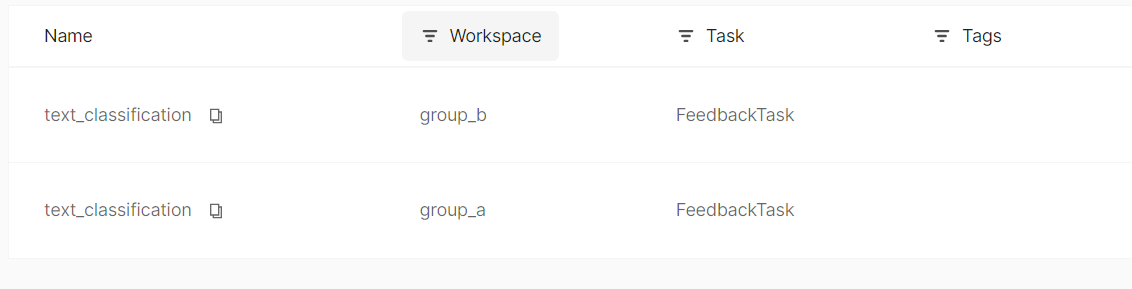

- Option with `group_personal`: We assign the workspaces and then we push the dataset with the corresponding records in each personal workspace.

In [ ]:
from argilla.client.feedback.utils import assign_workspaces

wk_group_personal = assign_workspaces(
    assignments=assignments,
    workspace_type="group_personal"
)
wk_group_personal

In [ ]:
for group, users in assignments.items():
    for user in users.keys():
        dataset = rg.FeedbackDataset.for_text_classification(
            labels=["World", "Sports", "Business", "Sci/Tech"],
            guidelines="Classify the articles into one of the four categories.",
        )
        assigned_records = users[user]
        dataset.add_records(assigned_records)
        try:
            remote_dataset = dataset.from_argilla(name="text_classification", workspace=user)
            remote_dataset.delete()
        except Exception:
            remote_dataset = dataset.push_to_argilla(name="text_classification", workspace=user)

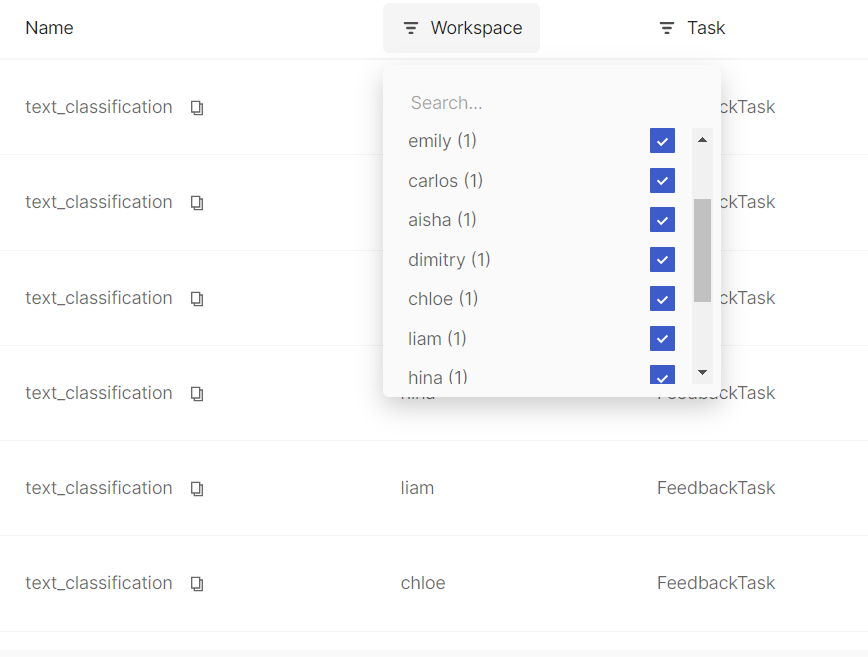

<div class="alert alert-info">
Note

A last option would be to use a common workspace, so that the annotators will filter the records using the [metadata](./add-metadata-003.ipynb) according to the group they belong to:

```python
# Add the metadata to the existing records using id to identify each record
id_modified_records = {}
for group, users in assignments.items():
    assigned_records = next(iter(assignments[group].values()))
    for record in assigned_records:
        record_id = id(record)
        if record_id not in id_modified_records:
            id_modified_records[record_id] = record
            record.metadata["annotator_groups"] = []
        if group not in id_modified_records[record_id].metadata["annotator_groups"]:
            id_modified_records[record_id].metadata["annotator_groups"].append(group)

# Get the unique records with their updated metadata
modified_records = list(id_modified_records.values())

# Push the dataset with the modified records
dataset = rg.FeedbackDataset.for_text_classification(
    labels=["World", "Sports", "Business", "Sci/Tech"],
    guidelines="Classify the articles into one of the four categories.",
    metadata_properties=[rg.TermsMetadataProperty(name="annotator_groups")]
)
dataset.add_records(modified_records)
remote_dataset = dataset.push_to_argilla(name="text-classification_assignment_metadata", workspace="argilla")
```
</div>

### Working with a List of Users

This section will address the workflow to assign records to a list of users.

#### 1. Get the users and records

In this scenario, we will continue working with the same annotators as previously, but this time without forming groups. They will individually annotate a total of one thousand records.

> Note: If you have skipped the previous section, you can simply write a list of users.

In [ ]:
# Get only those users with the role "annotator"
users = [user for user in rg.User.list() if user.role == "annotator"]
print('Number of users:', len(users))

In [ ]:
# Get the records
records = [record for record in dataset]
print('Number of records:', len(records))

#### 2. Assign the records

We will use the `assign_records` function to assign the annotations. We will specify the following parameters:

 - `users`: This will be our list of users.
 - `records`: The list of 1000 records.
 - `overlap`: We will set the overlap value to 2, as we want to have at least 2 annotations per record.
 - `shuffle`: To avoid any kind of bias, we will set it to `True`, so the samples are shuffled before the assignment.

 > Note: If a user in Argilla is created, the username and first name will be the names provided, the default password is "12345678" and they will have the role of "annotator".

In [ ]:
from argilla.client.feedback.utils import assign_records

assignments = assign_records(
    users=users,
    records=records,
    overlap=2,
    shuffle=True
)

In this case, the output is structured as a dictionary with the user as a key and a list of their assigned records as values. And, as the users are 10, each annotator will have 200 records assigned as the overlap was set to 2.

#### 3. Push the assigned records

Now, we will need to push the dataset to their private workspaces according to the assignments. For this purpose, we will use again the `assign_workspaces` function with the following arguments:

- `assignments`: This is the assignments dictionary from the previous step.
- `workspace_type`: We will set it to `individual`, so that each user will have the corresponding dataset in its personal workspace.

In [ ]:
from argilla.client.feedback.utils import assign_workspaces

wk_individual = assign_workspaces(
    assignments=assignments,
    workspace_type="individual"
)
wk_individual

In [ ]:
for username, records in assignments.items():
    dataset = rg.FeedbackDataset.for_text_classification(
        labels=["World", "Sports", "Business", "Sci/Tech"],
        guidelines="Classify the articles into one of the four categories.",
    )
    dataset.add_records(records)
    try:
        remote_dataset = dataset.from_argilla(name="text-classification", workspace=username)
        remote_dataset.delete()
    except Exception: 
        remote_dataset = dataset.push_to_argilla(name="text-classification", workspace=username)

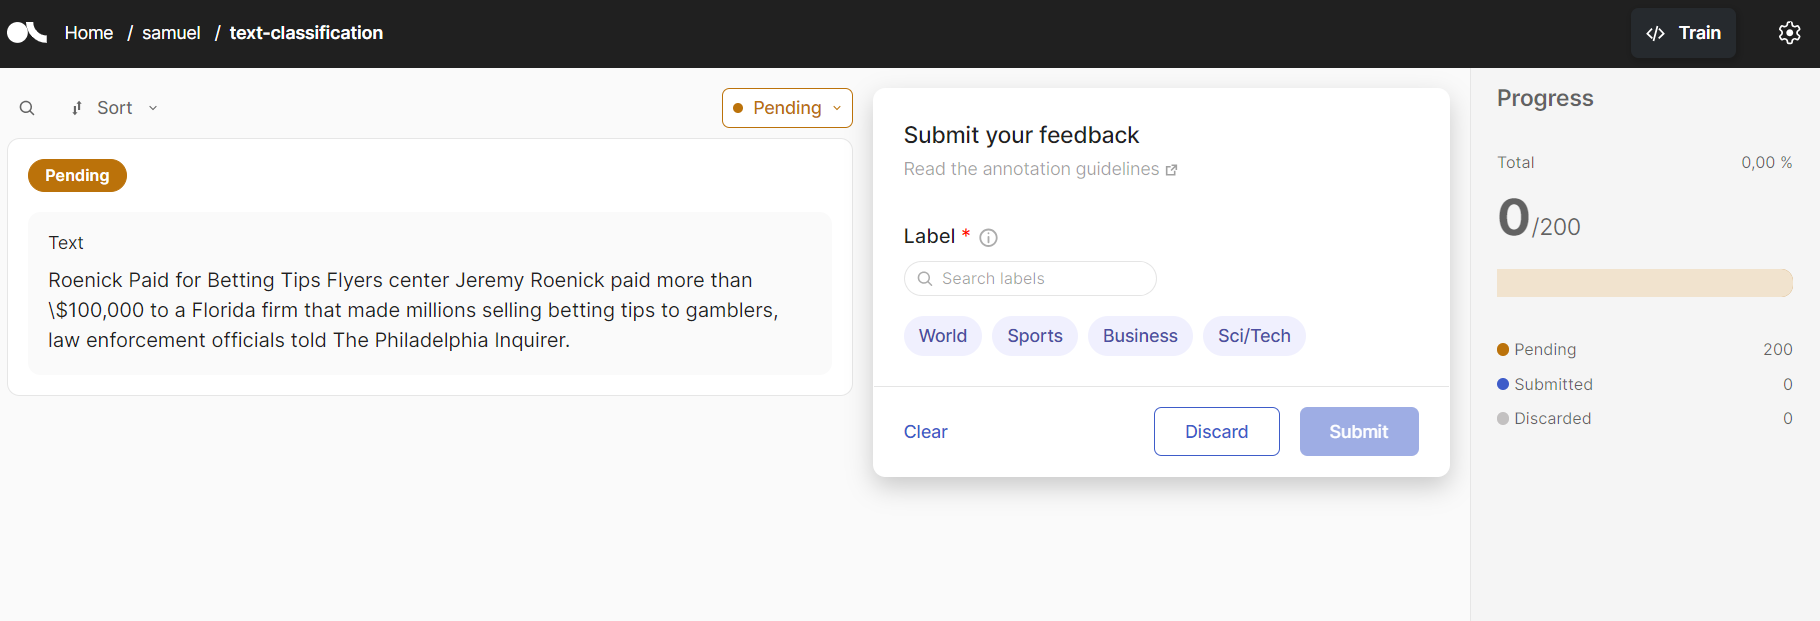

<div class="alert alert-info">
Note

As when we work with groups, it is also possible to use a common workspace, where each annotator will filter its records using the [metadata](./add-metadata-003.ipynb):

```python
#Add the metadata to the existing records using id to identify each record
id_modified_records = {}
for username, records in assignments.items():
    for record in records:
        record_id = id(record)
        if record_id not in id_modified_records:
            id_modified_records[record_id] = record
            record.metadata["annotators"] = []
        if username not in id_modified_records[record_id].metadata["annotators"]:
            id_modified_records[record_id].metadata["annotators"].append(username)

# Get the unique records with their updated metadata
modified_records = list(id_modified_records.values())

# Push the dataset with the modified records
dataset = rg.FeedbackDataset.for_text_classification(
        labels=["World", "Sports", "Business", "Sci/Tech"],
        guidelines="Classify the articles into one of the four categories.",
        metadata_properties=[rg.TermsMetadataProperty(name="annotators")]
    )
dataset.add_records(modified_records)
remote_dataset = dataset.push_to_argilla(name="text-classification_assignment_metadata", workspace="argilla")
```
</div>

## Conclusion

To sum up, we have shown how to assign records with full and controlled overlap. In scenarios involving controlled overlap, we explored the methods for distributing records among groups of annotators and a specified list of users through the use of `assign_records` and `assign_workspaces`. Additionally, we examined the technique for transferring these allocated records to their respective workspaces. In the [next tutorial](./add-metadata-003.ipynb), we will see how we can add metadata properties to our dataset.